# Perdas do Conversor NPC
## Perdas de comutação e Perdas de Condução

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def detectCommutation(y):
    """
    The function returns 1 where the signal has a positive commutation and
    -1 where the signal has a negative commutation.

    :param y: (numpy.array) The signal to the commutation analysis.
    :return: numpy.array
    """
    y1 = y[:-1]
    y2 = y[1:]

    diff = y2 - y1

    return y1, y2, diff


def rmsValue(signal):
    """
    Calculate the RMS value.
    :param signal: (numpy.array) The signal to do the RMS calculation.
    :return: float
    """

    return np.sqrt(np.sum(np.power(signal, 2)) / signal.size)


def conductionLoss_function(Vx0, Rx0, current):
    """
    x is CE (Collector-Emitter) for IGBTs and F (Forward) for diodes
    """

    return Vx0 * np.mean(current) + Rx0 * np.power(rmsValue(current), 2)


In [3]:
def tableSwitchingLosses3(
    switch_s1, switch_s2, current, duration, Vdc_converter,
    eon_params1=[6.61365789e-11, 7.07476943e-08, 4.98733483e-05, 2.58300197e-04],
    eoff_params1=[ 1.30001782e-10, -1.55596680e-07,  1.49277835e-04, -1.42146582e-04],
    erec_params1=[ 9.18281788e-11, -1.86522453e-07,  1.26916359e-04, -3.31200108e-04],
    eon_params2=[ 2.48136613e-11, -1.86552515e-08,  4.05037654e-05,  7.55983114e-05],
    eoff_params2=[ 1.19125387e-10, -1.26717009e-07,  1.48696175e-04, -2.81543803e-04],
    erec_params2=[ 1.80895231e-10, -2.35704421e-07,  1.27996462e-04, -2.08736552e-04],
    Vce_datasheet=600):
    """
    Calculate the switching loses to a 3-level inverter, a NPC leg.

    Curves:
        * eon_params1, eoff_params1 and erec_params1: IGBT1/DIODE5
        * eon_params2, eoff_params2 and erec_params2: IGBT2/DIODE1

    Default values used and more information is available (to measure) in:
    https://www.semikron.com/dl/service-support/downloads/download/semikron-datasheet-skim301mli12e4-23918880.pdf

    :param switch_s1: (list or array-like) The command of the top switch.
    :param switch_s2: (list or array-like) The command of the bottom switch.
    :param current: (list or array-like) The current that crosses the converter.
    :param duration: (float) The total duration of the signals ``switch_s1`` and ``current``.
        For power calculation in Watts.
    :param Vcc_converter: (float) The DC bus voltage value of the converter.
    :param eon_params1: (list or array-like) Coefficients of the curve Eon losses for IGBT1/DIODE5.
    :param eoff_params1: (list or array-like) Coefficients of the curve Eoff losses for IGBT1/DIODE5.
    :param erec_params1: (list or array-like) Coefficients of the curve Erec losses for IGBT1/DIODE5.
    :param eon_params2: (list or array-like) Coefficients of the curve Eon losses for IGBT2/DIODE1.
    :param eoff_params2: (list or array-like) Coefficients of the curve Eoff losses for IGBT2/DIODE1.
    :param erec_params2: (list or array-like) Coefficients of the curve Erec losses for IGBT2/DIODE1.
    :param Vcc_datasheet: (float) The DC voltage value for the curves reference in datasheet.
    :return: tuple of dicts
    """

    # Bring the signal to the numpy.array type
    switch_s1 = np.array(switch_s1)
    switch_s2 = np.array(switch_s2)

    current = np.array(current)

    # Creating the polynomials from the coefficients and put in the real DC Bus voltage
    eon1 = (Vdc_converter/2)/Vce_datasheet * np.poly1d(eon_params1)
    eoff1 = (Vdc_converter/2)/Vce_datasheet * np.poly1d(eoff_params1)
    erec1 = (Vdc_converter/2)/Vce_datasheet * np.poly1d(erec_params1)
    eon2 = (Vdc_converter/2)/Vce_datasheet * np.poly1d(eon_params2)
    eoff2 = (Vdc_converter/2)/Vce_datasheet * np.poly1d(eoff_params2)
    erec2 = (Vdc_converter/2)/Vce_datasheet * np.poly1d(erec_params2)

    # Detect the commutation in top and bottom switches
    _, _, commut1 = detectCommutation(switch_s1)
    _, _, commut2 = detectCommutation(switch_s2)

    # Detect the current direction
    current0 = current[1:]

    # Taking the index where the current is positive and negative
    pos_current = current0 >= 0
    neg_current = current0 < 0

    # Create the vectors called stateX where X is:
    #    -> A: The commutation to neutral point to positive (0 -> P)
    #    -> B: The commutation to positive point to neutral (P -> 0)
    #    -> C: The commutation to neutral point to negative (0 -> N)
    #    -> D: The commutation to negative point to neutral (N -> 0)
    stateA = commut1 == 1
    stateB = commut1 == -1
    stateC = commut2 == -1
    stateD = commut2 == 1

    # And for each state we have a different current direction
    stateA_cur_pos = np.abs(stateA * pos_current)
    stateA_cur_neg = np.abs(stateA * neg_current)

    stateB_cur_pos = np.abs(stateB * pos_current)
    stateB_cur_neg = np.abs(stateB * neg_current)

    stateC_cur_pos = np.abs(stateC * pos_current)
    stateC_cur_neg = np.abs(stateC * neg_current)

    stateD_cur_pos = np.abs(stateD * pos_current)
    stateD_cur_neg = np.abs(stateD * neg_current)

    # For 'S1'
    s1_eon = eon1(np.abs(current0[stateA_cur_pos]))
    s1_eoff = eoff1(np.abs(current0[stateB_cur_pos]))

    # For 'S2'
    s2_eon = eon2(np.abs(current0[stateD_cur_pos]))
    s2_eoff = eoff2(np.abs(current0[stateC_cur_pos]))

    # For 'S3'
    s3_eon = eon2(np.abs(current0[stateB_cur_neg]))
    s3_eoff = eoff2(np.abs(current0[stateA_cur_neg]))

    # For 'S4'
    s4_eon = eon1(np.abs(current0[stateC_cur_neg]))
    s4_eoff = eoff1(np.abs(current0[stateD_cur_neg]))

    ###

    # For 'D1'
    d1_rec = erec2(np.abs(current0[stateB_cur_neg]))

    # For 'D4'
    d4_rec = erec2(np.abs(current0[stateD_cur_pos]))

    # For 'D5'
    d5_rec = erec1(np.abs(current0[stateA_cur_pos]))

    # For 'D6'
    d6_rec = erec1(np.abs(current0[stateC_cur_neg]))

    # Prevent negative values of all polynomials
    s1_eon[s1_eon < 0] = 0
    s1_eoff[s1_eoff < 0] = 0
    s2_eon[s2_eon < 0] = 0
    s2_eoff[s2_eoff < 0] = 0
    s3_eon[s3_eon < 0] = 0
    s3_eoff[s3_eoff < 0] = 0
    s4_eon[s4_eon < 0] = 0
    s4_eoff[s4_eoff < 0] = 0
    d1_rec[d1_rec < 0] = 0
    d4_rec[d4_rec < 0] = 0
    d5_rec[d5_rec < 0] = 0
    d6_rec[d6_rec < 0] = 0

    P_on = {
        'S1': 1 / duration * np.sum(s1_eon),
        'S2': 1 / duration * np.sum(s2_eon),
        'S3': 1 / duration * np.sum(s3_eon),
        'S4': 1 / duration * np.sum(s4_eon),

        'D1': 0.0,
        'D4': 0.0,

        'D5': 0.0,
        'D6': 0.0,
        'D2': 0.0,
        'D3': 0.0}

    P_off = {
        'S1': 1 / duration * np.sum(s1_eoff),
        'S2': 1 / duration * np.sum(s2_eoff),
        'S3': 1 / duration * np.sum(s3_eoff),
        'S4': 1 / duration * np.sum(s4_eoff),

        'D1': 1 / duration * np.sum(d1_rec),
        'D4': 1 / duration * np.sum(d4_rec),

        'D5': 1 / duration * np.sum(d5_rec),
        'D6': 1 / duration * np.sum(d6_rec),
        'D2': 0.0,
        'D3': 0.0}

    return P_on, P_off

In [4]:
def tableConductionLosses3(switch_s1, switch_s2, current,
                           VCE0_IGBT1=.8, VCE0_IGBT2=.8,
                           VF0_DIODE1=1.30, VF0_DIODE2=1.30,
                           VF0_Diode5=1.30, RCE0_IGBT1=3.3*1e-3,
                           RCE0_IGBT2=3.3*1e-3, RF0_DIODE1=3*1e-3,
                           RF0_DIODE2=3*1e-3, RF0_DIODE5=2.8e-3):
    """
    Calculate the conduction loses to a 3-level inverter, a NPC leg.

    Default values used is available in:
    https://www.semikron.com/dl/service-support/downloads/download/semikron-datasheet-skim301mli12e4-23918880.pdf

    :param switch_s1: (list or array-like) The command of the top switch.
    :param switch_s2: (list or array-like) The command of the bottom switch.
    :param current: (list or array-like) The current that crosses the converter.
    :param VCE0_IGBT1: (float) Is the threshold voltage of the IGBT1 switch, present in the datasheet of the
        converter. (VCE0, 25°C, typ)
    :param VCE0_IGBT2: (float) Is the threshold voltage of the IGBT2 switch, present in the datasheet of the
        converter. (VCE0, 25°C, typ)
    :param VF0_DIODE1: (float) Is the threshold voltage of the DIODE1 switch, present in the datasheet of the
        converter. (VF0, 25°C, typ)
    :param VF0_DIODE2: (float) Is the threshold voltage of the DIODE2 switch, present in the datasheet of the
        converter. (VF0, 25°C, typ)
    :param VF0_Diode5: (float) Is the threshold voltage of the DIODE5 switch, present in the datasheet of the
        converter. (VF0, 25°C, typ)

    :param RCE0_IGBT1: (float) Is the series resistance of the IGBT1 switch, present in the datasheet of the
        converter. (rCE, 25°C, typ)
    :param RCE0_IGBT2: (float) Is the series resistance of the IGBT2 switch, present in the datasheet of the
        converter. (rCE, 25°C, typ)
    :param RF0_DIODE1: (float) Is the series resistance of the DIODE1, present in the datasheet of the converter.
        (rF, 25°C, typ)
    :param RF0_DIODE2: (float) Is the series resistance of the DIODE2, present in the datasheet of the converter.
        (rF, 25°C, typ)
    :param RF0_DIODE5: (float) Is the series resistance of the DIODE5, present in the datasheet of the converter.
        (rF, 25°C, typ)
    :return: dict
    """

    # Bring the signal to the numpy.array type
    switch_s1 = np.array(switch_s1)
    switch_s2 = np.array(switch_s2)
    current = np.array(current)

    # Creating the current vectors
    pos_current = np.zeros(current.size)
    neg_current = np.zeros(current.size)

    pos_current[current >= 0] = current[current >= 0]
    neg_current[current < 0] = current[current < 0]

    # Creating the logical moments of conduction:
    #    -> S1_S2 : When the 2 top IGBTs are conducting
    #    -> S2_S3 : When the 2 middle IGBTs are conducting
    #    -> S3_S4 : When the 2 bottom IGBTs are conducting
    S1_S2 = np.logical_and(switch_s1, switch_s2)
    S2_S3 = np.logical_and(np.logical_not(switch_s1), switch_s2)
    S3_S4 = np.logical_and(np.logical_not(switch_s1),
                           np.logical_not(switch_s2))

    current_S1_S2 = np.abs(pos_current * S1_S2)
    current_D1_D2 = np.abs(neg_current * S1_S2)

    current_S2_D5 = np.abs(pos_current * S2_S3)
    current_S3_D6 = np.abs(neg_current * S2_S3)

    current_D3_D4 = np.abs(pos_current * S3_S4)
    current_S3_S4 = np.abs(neg_current * S3_S4)

    s1_cd = conductionLoss_function(VCE0_IGBT1, RCE0_IGBT1, current_S1_S2)
    s2_cd = (conductionLoss_function(VCE0_IGBT2, RCE0_IGBT2, current_S1_S2) +
             conductionLoss_function(VCE0_IGBT2, RCE0_IGBT2, current_S2_D5))

    s3_cd = (conductionLoss_function(VCE0_IGBT2, RCE0_IGBT2, current_S3_D6) +
             conductionLoss_function(VCE0_IGBT2, RCE0_IGBT2, current_S3_S4))

    s4_cd = conductionLoss_function(VCE0_IGBT1, RCE0_IGBT1, current_S3_S4)

    d1_cd = conductionLoss_function(VF0_DIODE1, RF0_DIODE1, current_D1_D2)

    d2_cd = conductionLoss_function(VF0_DIODE2, RF0_DIODE2, current_D1_D2)
    d3_cd = conductionLoss_function(VF0_DIODE2, RF0_DIODE2, current_D3_D4)

    d4_cd = conductionLoss_function(VF0_DIODE1, RF0_DIODE1, current_D3_D4)

    d5_cd = conductionLoss_function(VF0_Diode5, RF0_DIODE5, current_S2_D5)
    d6_cd = conductionLoss_function(VF0_Diode5, RF0_DIODE5, current_S3_D6)

    P_cd = {'S1': s1_cd, 'S2': s2_cd, 'S3': s3_cd,
            'S4': s4_cd, 'D1': d1_cd, 'D2': d2_cd,
            'D3': d3_cd, 'D4': d4_cd, 'D5': d5_cd,
            'D6': d6_cd}

    return P_cd

## Testing the Switching Losses
### 1. Testando a detecção de comutação

In [5]:
import numpy as np
import matplotlib.pyplot as plt

y = np.array(list('AABBBBCCBBBAABBAABBBCCCBBBCC'))

index1 = y == 'A'
index2 = y == 'B'
index3 = y == 'C'

s1 = np.zeros(len(y))
s2 = np.zeros(len(y))
s3 = np.zeros(len(y))
s4 = np.zeros(len(y))

s1[index1] = 1
s2[index1] = 1

s2[index2] = 1
s3[index2] = 1

s3[index3] = 1
s4[index3] = 1

print('Trocas de Estado:')

print(' S2 !S1  ->  S1  S2: %3d'   % 2)
print(' S1  S2  ->  S2 !S1: %3d'  % 3)
print(' S2 !S1  -> !S1 !S2: %3d' % 3)
print('!S1 !S2  ->  S2 !S1: %3d'  % 2)

Trocas de Estado:
 S2 !S1  ->  S1  S2:   2
 S1  S2  ->  S2 !S1:   3
 S2 !S1  -> !S1 !S2:   3
!S1 !S2  ->  S2 !S1:   2


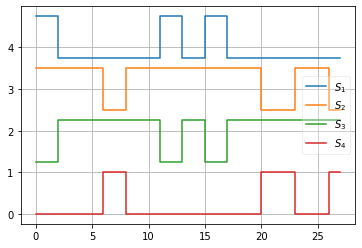

In [6]:
plt.step(range(s1.size), s1+3.75, where='post', label='$S_1$')
plt.step(range(s2.size), s2+2.5, where='post', label='$S_2$')
plt.step(range(s3.size), s3+1.25, where='post', label='$S_3$')
plt.step(range(s4.size), s4, where='post', label='$S_4$')
plt.legend(loc=7, framealpha=.3)
xmin, _ = plt.xlim()
plt.grid()
plt.show()

### 2. Mostrando o sinal simulado para o teste de perdas de comutação

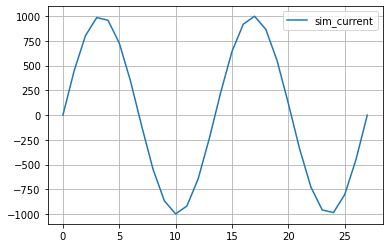

In [7]:
size = y.size

t = np.linspace(0, 2/60, size)
sim_current = 1000*np.sin(2*np.pi*60*t)

plt.plot(sim_current, label='sim_current')
plt.grid(True)
plt.legend()
plt.show()

#### 2.1 Obtendo os parâmetros para as funções

In [8]:
# Manual da Semikron (SKiM301MLI12E4)

# Curvas da Fig. 3: Typ. IGBT1 & Diode5 turn-on /-off energy = f (IC)

Ic_pts1   = [150., 200. , 300. , 400., 500., 600.]

eon_pts1  = [ 10.,  14. ,  22.5,  36., 55. ,  70.]
erec_pts1 = [ 15.,  17.5,  24. ,  26., 27.5,  29.]
eoff_pts1 = [ 20.,  25. ,  34. ,  43., 52. ,  61.]

eon_params1  = np.polyfit(Ic_pts1, eon_pts1,  3) / 1e3
eoff_params1 = np.polyfit(Ic_pts1, eoff_pts1, 3) / 1e3
erec_params1 = np.polyfit(Ic_pts1, erec_pts1, 3) / 1e3

eon1  = np.poly1d(eon_params1)
eoff1 = np.poly1d(eoff_params1)
erec1 = np.poly1d(erec_params1)

# Curvas da Fig. 15: Typ. IGBT2 & Diode1 turn-on /-off energy = f (IC)

Ic_pts2   = [150., 200. , 300. , 400., 500., 600.]

eon_pts2  = [  5.,  7. ,  11. ,  15., 19. ,  23.]
erec_pts2 = [ 15.,  17.,  22.5,  25., 27.5,  31.]
eoff_pts2 = [ 20.,  25. , 36. ,  47., 58. ,  69.]

eon_params2  = np.polyfit(Ic_pts2, eon_pts2,  3) / 1e3
eoff_params2 = np.polyfit(Ic_pts2, eoff_pts2, 3) / 1e3
erec_params2 = np.polyfit(Ic_pts2, erec_pts2, 3) / 1e3

eon2  = np.poly1d(eon_params2)
eoff2 = np.poly1d(eoff_params2)
erec2 = np.poly1d(erec_params2)

### 3. Parametrizando as curvas $E_{on}$, $E_{off}$ e $E_{rec}$, retiradas de um manual da Semikron para o teste das perdas em comutação com os sinais acima

In [9]:
# Parâmetros de um manual da Semikron (SKiM301MLI12E4)

np.set_printoptions(precision=2)

print('Typ. IGBT1 & Diode5')
print('eon_params:', eon_params1)
print('eoff_params:', eoff_params1)
print('erec_params:', erec_params1)

print('\nTyp. IGBT2 & Diode1')
print('eon_params:', eon_params2)
print('eoff_params:', eoff_params2)
print('erec_params:', erec_params2)

Vcc = 600

Vo_IGBT1 = 2.05 # [V]
Ro_IGBT1 = 3.8*1e-3 # [ohm]

Vo_IGBT2 = 2.05 # [V]
Ro_IGBT2 = 3.8*1e-3 # [ohm]

Vo_Diode1 = 2.55 #[V] 
Ro_Diode1 = 3.4*1e-3 # [ohm]

Vo_Diode2 = 2.55 #[V] 
Ro_Diode2 = 3.4*1e-3 # [ohm]

Vo_Diode5 = 2.49 #[V] 
Ro_Diode5 = 3.2 *1e-3 # [ohm]

Typ. IGBT1 & Diode5
eon_params: [-4.27e-10  6.25e-07 -1.34e-04  1.82e-02]
eoff_params: [ 3.73e-11 -4.70e-08  1.09e-04  4.71e-03]
erec_params: [ 1.75e-10 -2.73e-07  1.54e-04 -2.92e-03]

Typ. IGBT2 & Diode1
eon_params: [-4.62e-25  1.56e-22  4.00e-05 -1.00e-03]
eoff_params: [-3.73e-11  4.70e-08  9.14e-05  5.29e-03]
erec_params: [ 1.66e-10 -2.18e-07  1.21e-04  8.47e-04]


In [10]:
P_on, P_off = tableSwitchingLosses3(
    s1, s2, sim_current, t[-1], 
    eon1, eoff1, erec1, eon2, eoff2, erec2)

### 7. Resultado Final das potências dissipadas de cada um dos semicondutores $S_1$, $S_2$, $D_1$ e $D_2$ , em Watts

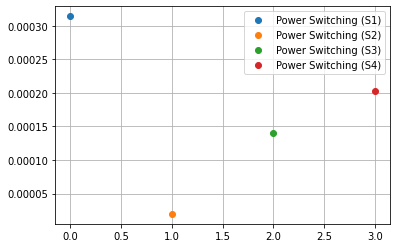

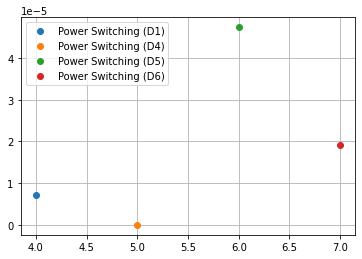

In [11]:
plt.plot([0], P_on['S1']+P_off['S1'], 'o', label='Power Switching (S1)')
plt.plot([1], P_on['S2']+P_off['S2'], 'o', label='Power Switching (S2)')
plt.plot([2], P_on['S3']+P_off['S3'], 'o', label='Power Switching (S3)')
plt.plot([3], P_on['S4']+P_off['S4'], 'o', label='Power Switching (S4)')
plt.grid()
plt.legend()
plt.show()

plt.plot([4], P_on['D1']+P_off['D1'], 'o', label='Power Switching (D1)')
plt.plot([5], P_on['D4']+P_off['D4'], 'o', label='Power Switching (D4)')
plt.plot([6], P_on['D5']+P_off['D5'], 'o', label='Power Switching (D5)')
plt.plot([7], P_on['D6']+P_off['D6'], 'o', label='Power Switching (D6)')
plt.grid()
plt.legend()
plt.show()

### Ap. Gráfico com os polinômios gerados para cada equação de energia

In [12]:
i = np.linspace(0, 1000, 200)

eon  = eon2
eoff = eoff2
erec = erec2

In [13]:
eon_p  = eon(i)
eoff_p = eoff(i)
erec_p = erec(i)

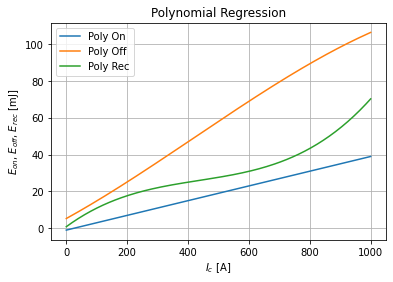

In [14]:
plt.plot(i, eon_p *1e3, label='Poly On')
plt.plot(i, eoff_p*1e3, label='Poly Off')
plt.plot(i, erec_p*1e3, label='Poly Rec')
plt.title('Polynomial Regression') 
plt.xlabel('$I_c$ [A]') 
plt.ylabel('$E_{on}$, $E_{off}$, $E_{rec}$ [mJ]')
plt.grid()
plt.legend()
# plt.xlim(100, 600)
plt.show()

## Testing the Conduction Losses

### 1. Generating the signals for test

In [15]:
Vdc = 800

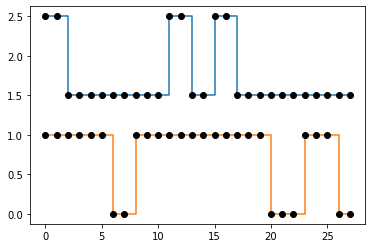

In [16]:
t = np.arange(0, s1.size, 1)

plt.step(t, s1+1.5, where='post')
plt.plot(s1+1.5, 'ko')
plt.step(t, s2, where='post')
plt.plot(s2, 'ko')
plt.show()

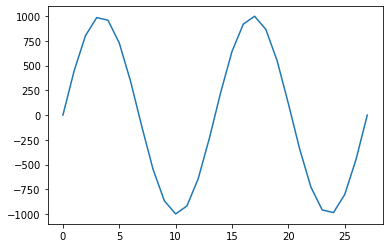

In [17]:
plt.plot(sim_current)

In [19]:
P_cd = tableConductionLosses3(
    s1, s2, sim_current, 
    Vo_IGBT1, Vo_IGBT2, 
    Vo_Diode1, Vo_Diode2, Vo_Diode2,
    Ro_IGBT1, Ro_IGBT2,
    Ro_Diode1, Ro_Diode2, Ro_Diode5)

### 6. Resultado Final, as perdas em comutação para cada uma dos semicondutores, em Watts

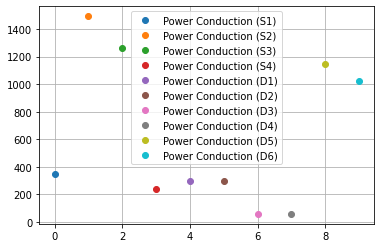

In [22]:
plt.plot([0], P_cd['S1'], 'o', label='Power Conduction (S1)')
plt.plot([1], P_cd['S2'], 'o', label='Power Conduction (S2)')
plt.plot([2], P_cd['S3'], 'o', label='Power Conduction (S3)')
plt.plot([3], P_cd['S4'], 'o', label='Power Conduction (S4)')
plt.plot([4], P_cd['D1'], 'o', label='Power Conduction (D1)')
plt.plot([5], P_cd['D2'], 'o', label='Power Conduction (D2)')
plt.plot([6], P_cd['D3'], 'o', label='Power Conduction (D3)')
plt.plot([7], P_cd['D4'], 'o', label='Power Conduction (D4)')
plt.plot([8], P_cd['D5'], 'o', label='Power Conduction (D5)')
plt.plot([9], P_cd['D6'], 'o', label='Power Conduction (D6)')
plt.grid()
plt.legend()
plt.show()